# Defining a categorical scoring system

This notebook explores how we translate a continuous system of risk values into an 11-step categorical scoring system.

In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
duckdb.sql("""INSTALL SPATIAL; LOAD SPATIAL; INSTALL HTTPFS; LOAD HTTPFS""")

In [3]:
%%time

version = '1.1.0'

dataset_uri = f's3://us-west-2.opendata.source.coop/carbonplan/carbonplan-ocr/output/fire-risk/vector/production/v{version}/geoparquet/buildings.parquet/**/data_*.parquet'

df = duckdb.sql(f"""
SELECT rps_2011, rps_2047
FROM read_parquet('{dataset_uri}')
""").df()

df.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 3min 6s, sys: 14.7 s, total: 3min 21s
Wall time: 27.1 s


,rps_2011,rps_2047
0,0.015370,0.028080
1,0.012864,0.009054
2,0.018747,0.020551
3,0.020955,0.017822
4,0.018548,0.020756


The distribution of risk values in this dataset is skewed with a very long tail at higher levels of risk. This skewed distribution can make it hard to distinguish both differences among risk levels at both higher and lower levels of risk. We overcome this, we design a scoring system with bins whose relative prevalence of buildings descend monotonically with increasing risk scores. We design the bins like this so that we can distinguish among risk values across the highly heterogeneous domain where risk values span multiple orders of magnitude.

Our approach is inspired by the WRC's increasingly fine percentile increments at higher levels of risk, as described in the supplemental materials for the Wildfire Risk to Communities project, specifically the `WRC_V2_DataPercentiles.xlsx` file found [here](https://www.fs.usda.gov/rds/archive/catalog/RDS-2020-0016-2). The WRC project uses "class breakpoints at 40th, 70th, 90th, and 95th percentile."  According to their documentation, that translates to breakpoints at the following values of RPS: `0.0188485, 0.0940430, 0.4081965, 0.7222983`. However, they based their percentiles and breakpoints on pixels as opposed to buildings, so they are inappropriate for us to use out-of-the-box. Given our focus on buildings, we will design our bins according to the distribution of risk values for buildings. 


We began with drafting a set of round number percentile scale breakpoints which grow increasingly close together as they near 100: `[75, 83, 88, 93, 96, 98, 99, 99.9, 99.99]`. 

In [4]:
percentiles = np.array([75, 82.5, 88, 92.5, 96, 98, 99.5, 99.9, 99.99])

We then calculate the RPS value for each of these percentiles.

In [26]:
bins = np.percentile(df[['rps_2011']].values, percentiles)

In [27]:
bins = np.insert(bins, 0, 0, axis=0)
bins = np.insert(
    bins, 1, 1e-64
)  # insert a very small non-zero number to differentiate the smallest bin by zero and non-zero
bins = np.insert(bins, 11, 100, axis=0)

All of this is probably easier shown than explained. When we use the bins calculated above to assign risk scores to the buildings in our dataset, the distribution of risk scores looks like below:

Text(0.5, 1.0, 'Counts of buildings in each score bin')

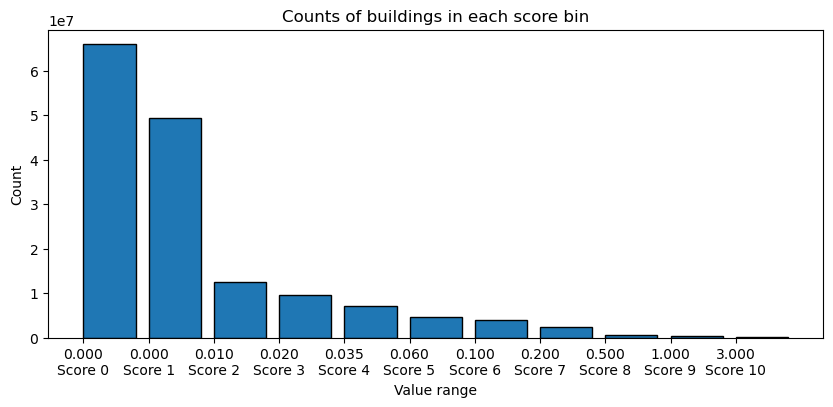

In [28]:
values = df['rps_2011'].values
counts, edges = np.histogram(values, bins=bins)
x = np.arange(len(counts))
width = 0.8
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.bar(x, counts, width=width, align='edge', edgecolor='black')
labels = [f'{bins[i]:.3f}\nScore {j}' for i, j in enumerate(range(len(bins) - 1))]
ax.set_xticks(x, labels)
ax.set_xlabel('Value range')
ax.set_ylabel('Count')
ax.set_title('Counts of buildings in each score bin')

Let's update the bin breakpoints to rounder numbers to support interpretability. Then, let's confirm that the rounding update still preserves general pattern of higher risk scores being less prevalent.

In [29]:
rounded_bins = [0.01, 0.02, 0.035, 0.06, 0.1, 0.2, 0.5, 1, 3]

We then assess the original percentiles from these rounded bins to ensure that the percentiles still decrease monotonically, with breakpoints that grow increasingly close together.

In [30]:
percentiles = stats.percentileofscore(df['rps_2011'].values, rounded_bins)
print(percentiles)

[74.00142786 82.01698995 88.10069347 92.60139336 95.50861902 97.96913477
 99.42245615 99.83471727 99.99060975]


In [31]:
bins = rounded_bins
bins = np.insert(bins, 0, 0, axis=0)
bins = np.insert(bins, 1, 1e-64, axis=0)
bins = np.insert(bins, 11, 100, axis=0)

As shown below, the bin breakpoints at higher risk levels are more spaced out (and more clustered at lower risk levels), while the corresponding percentiles are more clustered at higher risk levels and more spaced out at lower risk levels.

In [32]:
bins

array([0.0e+00, 1.0e-64, 1.0e-02, 2.0e-02, 3.5e-02, 6.0e-02, 1.0e-01,
       2.0e-01, 5.0e-01, 1.0e+00, 3.0e+00, 1.0e+02])

Text(0.5, 1.0, 'Counts of buildings in each score bin')

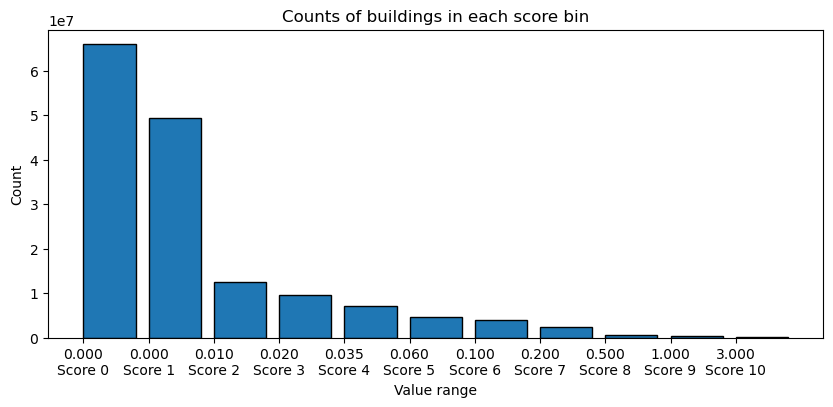

In [33]:
values = df['rps_2011'].values
counts, edges = np.histogram(values, bins=bins)
x = np.arange(len(counts))
width = 0.8
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.bar(x, counts, width=width, align='edge', edgecolor='black')
labels = [f'{bins[i]:.3f}\nScore {j}' for i, j in enumerate(range(len(bins) - 1))]
ax.set_xticks(x, labels)
ax.set_xlabel('Value range')
ax.set_ylabel('Count')
ax.set_title('Counts of buildings in each score bin')

Then let's see what the risk values look like for the future scenario:

Text(0.5, 1.0, 'Counts of buildings in each score bin')

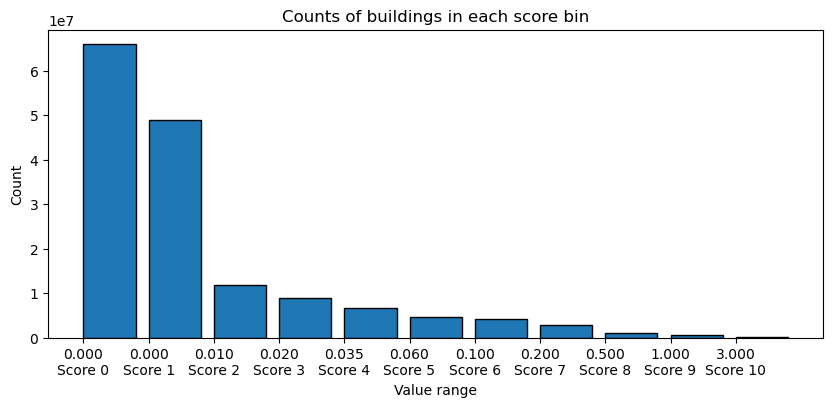

In [34]:
values = df['rps_2047'].values
counts, edges = np.histogram(values, bins=bins)
x = np.arange(len(counts))
width = 0.8
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.bar(x, counts, width=width, align='edge', edgecolor='black')
labels = [f'{bins[i]:.3f}\nScore {j}' for i, j in enumerate(range(len(bins) - 1))]
ax.set_xticks(x, labels)
ax.set_xlabel('Value range')
ax.set_ylabel('Count')
ax.set_title('Counts of buildings in each score bin')